# Import Related Package

In [1]:
# Config GPU Resource
# https://stackoverflow.com/questions/55788883/limiting-gpu-memory-usage-by-keras-tf-2019
# https://www.bookstack.cn/read/TensorFlow2.0/spilt.6.3b87bc87b85cbe5d.md

GPU_NUMBER = "0" 

import os
os.environ['CUDA_VISIBLE_DEVICES']=f"{GPU_NUMBER}"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(devices=gpus, device_type='GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# packages
from tensorflow import keras
import tensorflow.keras.layers 
import tensorflow.keras.backend
from tensorflow.keras import utils as np_utils
from tensorflow.python.client import device_lib
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# from focal_loss import *


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import struct
import pathlib
import os
import glob
import itertools
import seaborn as sns
import shutil
import joblib

import json

print("Devices", tf.config.list_physical_devices(device_type=None))

Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Global Enviroment Variable

In [2]:
# -------------------- preprocess --------------------
MODEL_DESCRIPTION = "1_8_pkts_28_features_archive"
MODEL_NAME = "gru"
SCRIPT_FILE_NAME = "2_GRU.ipynb" # You can't use libray directly to get ipynb name because it runs at jupyter.
CACHE_DIR_NAME = "gru_8_pkts_28_features"    

## -------------------- dependent/nonchange variables --------------------
classesJsonPath = "./classes.json"

MALWARE_TYPE = {}
with open(classesJsonPath) as jsonFile:
    MALWARE_TYPE = json.load(jsonFile)



NUMBER_OF_PKTS_PER_SESSION = int(CACHE_DIR_NAME.split("_")[1])
NUMBER_OF_FEATURES = int(CACHE_DIR_NAME.split("_")[3])

SAVE_DIRECTORY = f"model/{MODEL_NAME}/{MODEL_DESCRIPTION}"
CACHE_DIR = f"csv/{CACHE_DIR_NAME}"
CACHE_FILE_NAME = ["x_train.csv", "x_test.csv", "y_train.csv", "y_test.csv"]

pathlib.Path(SAVE_DIRECTORY).mkdir(parents=True, exist_ok=True)
# ==================== preprocess end ====================


# -------------------- Training Model --------------------
TRAINING_HISTORY_FILE_NAME = "training_log.csv"
LOSS = keras.losses.categorical_crossentropy  # categorical_crossentropy
OPTIMIZER = keras.optimizers.Adam()
EPOCHS_SIZE = 50 # 30
BATCH_SIZE = 64 # 64
# ==================== Training Model end ====================


# -------------------- Estimated Performace --------------------
LABELS = [key for key,_ in sorted(MALWARE_TYPE.items(), key=lambda x:x[1])]
ESTIMATED_ROOT_DIR = f"{SAVE_DIRECTORY}"
# ==================== Estimated Performace end ====================

print(json.dumps(MALWARE_TYPE, indent=4))
print(LABELS)


{
    "Amazon": 0,
    "CyberGhost": 1,
    "Deezer": 2,
    "Discord": 3,
    "Dropbox": 4,
    "Epic": 5,
    "Facebook": 6,
    "Hotspot": 7,
    "iTunes": 8,
    "Microsoft": 9,
    "ProtonVPN": 10,
    "Skype": 11,
    "Slack": 12,
    "SoulseekQt": 13,
    "Spotify": 14,
    "Steam": 15,
    "Telegram": 16,
    "TuneIn": 17,
    "TunnelBear": 18,
    "Ultrasurf": 19,
    "WhatsApp": 20,
    "Zoom": 21
}
['Amazon', 'CyberGhost', 'Deezer', 'Discord', 'Dropbox', 'Epic', 'Facebook', 'Hotspot', 'iTunes', 'Microsoft', 'ProtonVPN', 'Skype', 'Slack', 'SoulseekQt', 'Spotify', 'Steam', 'Telegram', 'TuneIn', 'TunnelBear', 'Ultrasurf', 'WhatsApp', 'Zoom']


# Read Cache File

In [3]:
print("---- check if the validation set are existed ----")
print("==== check if the validation set are existed end ====")

print("---- read csv ----")
xTrainRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[0]}").to_numpy()    
xTestRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[1]}").to_numpy()    
yTrainRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[2]}").replace(MALWARE_TYPE).to_numpy()    
yTestRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[3]}").replace(MALWARE_TYPE).to_numpy()    
xTrainRawData = xTrainRawData.reshape((-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES))
xTestRawData = xTestRawData.reshape((-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES))

print(xTrainRawData.shape)
print(xTestRawData.shape)

print(yTrainRawData.shape)
print(yTestRawData.shape)

print("==== read end ====")


print("---- normalized data ----")
"""
    refernece website:
        normalized (https://stackoverflow.com/questions/53870113/using-standardscaler-on-3d-data)
"""
yTrain = np_utils.to_categorical(yTrainRawData, len(MALWARE_TYPE))
yTest = np_utils.to_categorical(yTestRawData, len(MALWARE_TYPE))
# mode 1
# xTrainRawData = np.reshape(xTrainRawData, [-1, NUMBER_OF_FEATURES])
# xTestRawData = np.reshape(xTestRawData, [-1, NUMBER_OF_FEATURES])
# if hasValidationSet:
#     yValidation = np_utils.to_categorical(yValidationRawData, len(MALWARE_TYPE)) 
#     xValidationRawData =  np.reshape(xValidationRawData, [-1, NUMBER_OF_FEATURES]) 

# mode 2
xTrainRawData = np.reshape(xTrainRawData, [-1, NUMBER_OF_PKTS_PER_SESSION * NUMBER_OF_FEATURES])
xTestRawData = np.reshape(xTestRawData, [-1, NUMBER_OF_PKTS_PER_SESSION * NUMBER_OF_FEATURES])
    
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrainRawData)
xTest = scaler.transform(xTestRawData)


xTrain = np.reshape(xTrain, [-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES])
xTest = np.reshape(xTest, [-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES])
print(xTrain.shape)
print(xTest.shape)

print("==== normalized end ====")
print("---- save mean & std variables ----")
scalerMeanDF = pd.DataFrame(scaler.mean_)
scalerStdDF = pd.DataFrame(scaler.scale_)
scalerMeanDF.to_csv(f"{SAVE_DIRECTORY}/standardscaler_mean.csv", index=False, header=False)
scalerStdDF.to_csv(f"{SAVE_DIRECTORY}/standardscaler_std.csv", index=False, header=False)
joblib.dump(scaler, f"{SAVE_DIRECTORY}/standard_scaler_param.bin", compress=True)
print("==== save mean & std variables ====")
print("==== preprocess success ====")

---- check if the validation set are existed ----
==== check if the validation set are existed end ====
---- read csv ----
(262020, 8, 28)
(10109, 8, 28)
(262020, 1)
(10109, 1)
==== read end ====
---- normalized data ----
(262020, 8, 28)
(10109, 8, 28)
==== normalized end ====
---- save mean & std variables ----
==== save mean & std variables ====
==== preprocess success ====


# GRU

In [4]:
gruInput = keras.Input(shape=(xTrain.shape[1], xTrain.shape[2]))


cnn1DLayer = Conv1D(filters=64, kernel_size=5, padding='same', name='cnn_conv_1')(gruInput) # cnn1DLayer = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='cnn_conv_1')(cnn1DInput)
print("cnn1DLayer shape:", cnn1DLayer.shape)

gruLayer = GRU(64, return_sequences = True, name='gru_gru_1')(cnn1DLayer) 
print("gruLayer shape:", gruLayer.shape)

gruLayer = GRU(64, return_sequences = True, name='gru_gru_2')(gruLayer) 
# gruLayer = LeakyReLU()(gruLayer) #

gruLayer = GRU(64, return_sequences = True, name='gru_gru_3')(gruLayer) 
# gruLayer = LeakyReLU()(gruLayer) #

gruLayer = GRU(64, return_sequences = False, name='gru_gru_4')(gruLayer) 
gruLayer = LeakyReLU()(gruLayer) #


gruLayer = Flatten(name='gru_flatten')(gruLayer)


gruLayer = Dense(units=64, name='gru_dense_2')(gruLayer)
gruLayer = BatchNormalization(name='gru_BN_4')(gruLayer) #
gruLayer = LeakyReLU(name='gru_dense_2_output')(gruLayer)
gruLayer = Dropout(0.1,  name='gru_dense_2_dropout')(gruLayer) # 0.3


gruLayer = Dense(units=len(MALWARE_TYPE))(gruLayer)
gruOutput = Activation("softmax")(gruLayer)

gru = keras.Model(inputs=[gruInput], outputs=gruOutput)    
gru.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
gru.summary()

np_utils.plot_model(gru,to_file=f"{SAVE_DIRECTORY}/{MODEL_NAME}.png",show_shapes=True)

cnn1DLayer shape: (None, 8, 64)
gruLayer shape: (None, 8, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 28)]           0         
                                                                 
 cnn_conv_1 (Conv1D)         (None, 8, 64)             9024      
                                                                 
 gru_gru_1 (GRU)             (None, 8, 64)             24960     
                                                                 
 gru_gru_2 (GRU)             (None, 8, 64)             24960     
                                                                 
 gru_gru_3 (GRU)             (None, 8, 64)             24960     
                                                                 
 gru_gru_4 (GRU)             (None, 64)                24960     
                                                                 

# Training Stage

In [5]:
# https://blog.csdn.net/ygfrancois/article/details/84942803

historyLogger = tf.keras.callbacks.CSVLogger(f"{SAVE_DIRECTORY}/{TRAINING_HISTORY_FILE_NAME}", separator=",")


history = gru.fit(x=xTrain, y=yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS_SIZE,
                    callbacks=[historyLogger],                                                                                  
                    verbose=1)

gru.save(f"{SAVE_DIRECTORY}/{MODEL_NAME}.h5")
shutil.copy(os.getcwd() + "/" + SCRIPT_FILE_NAME , f"{SAVE_DIRECTORY}/{SCRIPT_FILE_NAME}") # copy source code

Epoch 1/50
4095/4095 [==============================] - 39s 9ms/step - loss: 0.3539 - accuracy: 0.8938
Epoch 2/50
4095/4095 [==============================] - 35s 9ms/step - loss: 0.1442 - accuracy: 0.9528
Epoch 3/50
4095/4095 [==============================] - 35s 9ms/step - loss: 0.1110 - accuracy: 0.9625
Epoch 4/50
4095/4095 [==============================] - 34s 8ms/step - loss: 0.0964 - accuracy: 0.9669
Epoch 5/50
4095/4095 [==============================] - 33s 8ms/step - loss: 0.0845 - accuracy: 0.9707
Epoch 6/50
4095/4095 [==============================] - 34s 8ms/step - loss: 0.0824 - accuracy: 0.9711
Epoch 7/50
4095/4095 [==============================] - 33s 8ms/step - loss: 0.0748 - accuracy: 0.9734
Epoch 8/50
4095/4095 [==============================] - 33s 8ms/step - loss: 0.0739 - accuracy: 0.9740
Epoch 9/50
4095/4095 [==============================] - 33s 8ms/step - loss: 0.0679 - accuracy: 0.9761
Epoch 10/50
4095/4095 [==============================] - 34s 8ms/step - l

c:\Users\CIA_Kenny\AppData\Local\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'model/gru/1_8_pkts_28_features_archive/2_GRU.ipynb'

# Estimate Performance

In [8]:
# Function
# https://zhuanlan.zhihu.com/p/40156908
def get_FLOPs(modelPath):
    tf.compat.v1.reset_default_graph()
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(modelPath)

            runMeta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=runMeta, cmd='op', options=opts)   
            return flops.total_float_ops

def plot_training_history(csvPath, savedDirPath):
    history = pd.read_csv(csvPath, sep=',', engine='python')
    plt.plot(history['accuracy'], label="acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(f"{savedDirPath}/train_acc.png")
    plt.show()
    plt.plot(history['loss'], label="loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(f"{savedDirPath}/train_loss.png")
    plt.show()



def cm_analysis(yTrue, yPred, fileName, labels, ymap=None, figSize=(10,10)):
    """
    reference: https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
    
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      yTrue:    true label of the data, with shape (nsamples,)
      yPred:    prediction of the data, with shape (nsamples,)
      fileName:  fileName of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original yTrue, yPred and labels must align.
      figSize:   the size of the figure plotted.
    """
    if ymap is not None:
        yPred = [ymap[yi] for yi in yPred]
        yTrue = [ymap[yi] for yi in yTrue]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(yTrue, yPred)#, labels=labels)
    cmSum = np.sum(cm, axis=1, keepdims=True)
    cmPerc = cm / cmSum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cmPerc[i, j]
            if i == j:
                s = cmSum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figSize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(fileName)

model/gru/1_8_pkts_28_features_archive/training_log.csv


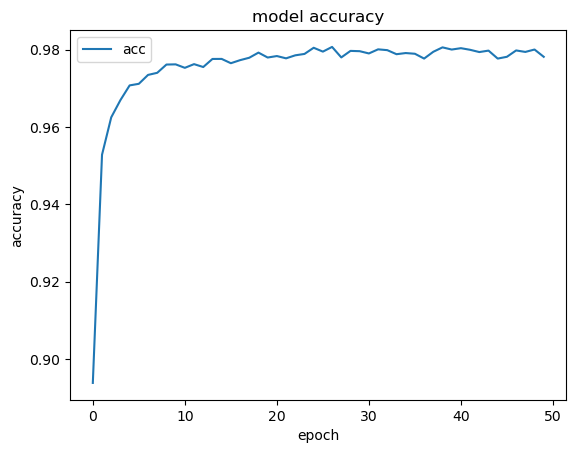

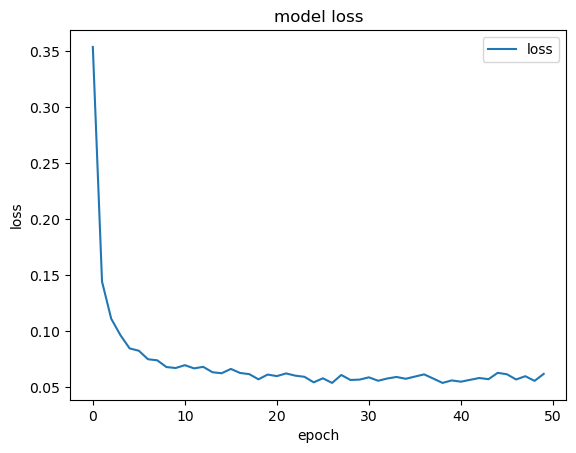

316/316 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

      Amazon       0.99      0.94      0.97       427
  CyberGhost       0.98      0.99      0.98       224
      Deezer       0.93      0.84      0.89       340
     Discord       0.94      0.90      0.92       134
     Dropbox       0.95      0.99      0.97       106
        Epic       0.99      0.98      0.99       391
    Facebook       0.91      0.95      0.93        88
     Hotspot       0.87      1.00      0.93       142
      iTunes       0.95      0.96      0.96       149
   Microsoft       0.88      0.74      0.80       141
   ProtonVPN       0.95      1.00      0.97       105
       Skype       0.86      0.88      0.87       185
       Slack       0.99      1.00      0.99       636
  SoulseekQt       0.99      1.00      1.00       151
     Spotify       0.96      0.96      0.96       636
       Steam       0.88      0.92      0.90       106
    Telegram       0.99   

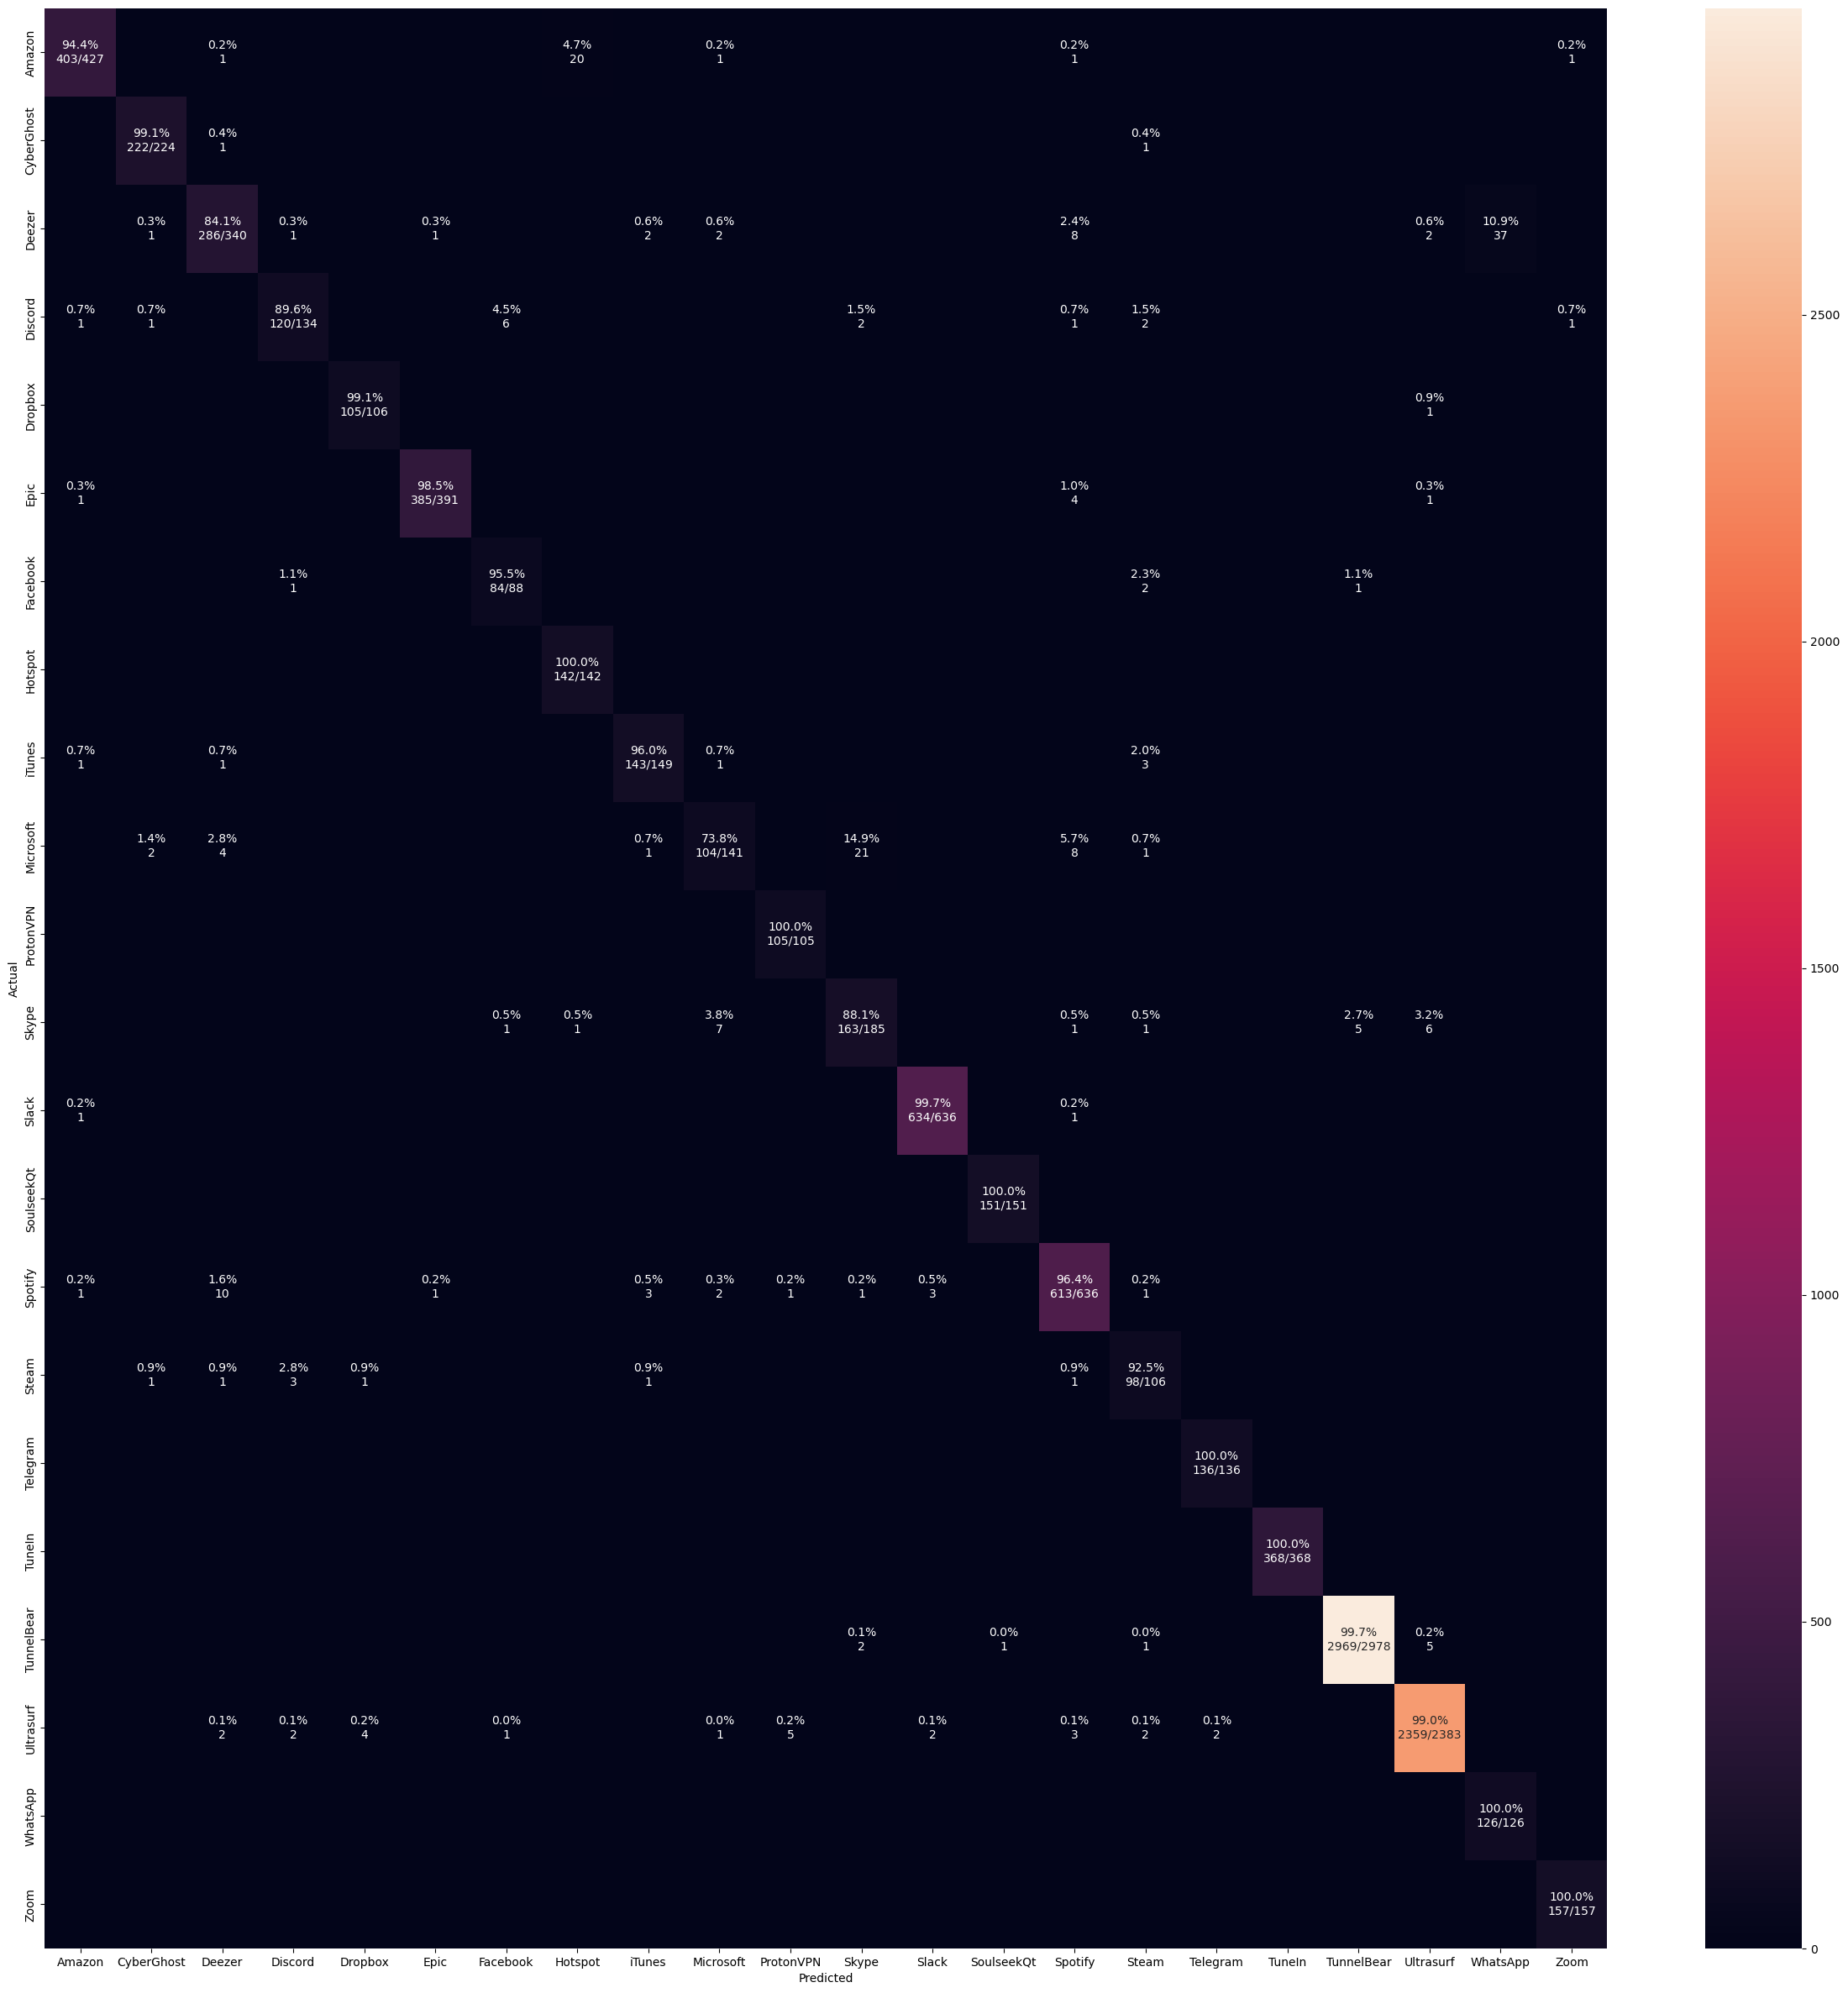

In [9]:
"""
    reference webiste:
        https://github.com/howl-anderson/WeatherBot_NLU/issues/4
        https://blog.csdn.net/jmh1996/article/details/114935105
"""

print(f"{ESTIMATED_ROOT_DIR}/training_log.csv")
# print(get_FLOPs("model/cnn2d_model_2.h5"))
# print(get_FLOPs("autoencoder_1dcnn/4/1dcnn.h5"))

plot_training_history(f"{ESTIMATED_ROOT_DIR}/{TRAINING_HISTORY_FILE_NAME}",  ESTIMATED_ROOT_DIR)

model = tf.keras.models.load_model(f"{ESTIMATED_ROOT_DIR}/{MODEL_NAME}.h5")
predictions = model.predict([xTest])
predictions = np.argmax(predictions,axis=1)
cm_analysis(np.argmax(yTest,axis=1), predictions, f"{ESTIMATED_ROOT_DIR}/confusion.png", LABELS, ymap=None, figSize=(30,30))

with open(f'{ESTIMATED_ROOT_DIR}/f1score.txt', 'w') as f:
    ans = classification_report(np.argmax(yTest,axis=1), predictions,  target_names=LABELS)
    f.write(ans)   
print(ans)